In [1]:
import pandas as pd
import numpy as np
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
import os
import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings("ignore")

In [2]:
spark = SparkSession.builder.getOrCreate()

22/09/11 23:39:55 WARN Utils: Your hostname, codespaces-4f50a9 resolves to a loopback address: 127.0.0.1; using 172.16.5.4 instead (on interface eth0)
22/09/11 23:39:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/11 23:39:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
schema = schema = StructType([
    StructField("acousticness", FloatType(), True),
    StructField("artists", StringType(), True),
    StructField("danceability", FloatType(), True),
    StructField("duration_ms", IntegerType(), True),
    StructField("energy", FloatType(), True),
    StructField("explicit", IntegerType(), True),
    StructField("id", StringType(), True),
    StructField("instrumentalness", FloatType(), True),
    StructField("key", IntegerType(), True),
    StructField("liveness", FloatType(), True),
    StructField("loudness", FloatType(), True),
    StructField("mode", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("popularity", IntegerType(), True),
    StructField("release_date", StringType(), True),
    StructField("speechiness", FloatType(), True),
    StructField("tempo", FloatType(), True),
    StructField("valence", FloatType(), True),
    StructField("year", IntegerType(), True)
    ])
df = spark.read.csv("data.csv",header=True, inferSchema=True, schema=schema)

In [4]:
df.show()

+------------+--------------------+------------+-----------+-------+--------+--------------------+----------------+---+--------+--------+----+--------------------+----------+------------+-----------+-------+-------+----+
|acousticness|             artists|danceability|duration_ms| energy|explicit|                  id|instrumentalness|key|liveness|loudness|mode|                name|popularity|release_date|speechiness|  tempo|valence|year|
+------------+--------------------+------------+-----------+-------+--------+--------------------+----------------+---+--------+--------+----+--------------------+----------+------------+-----------+-------+-------+----+
|       0.995| ['Carl Woitschach']|       0.708|     158648|  0.195|       0|6KbQ3uYMLKb5jDxLF...|           0.563| 10|   0.151| -12.428|   1|Singende Bataillo...|         0|        1928|     0.0506|118.469|  0.779|1928|
|       0.994|['Robert Schumann...|       0.379|     282133| 0.0135|       0|6KuQTIu1KoTTkLXKr...|           0.901| 

In [5]:
df.printSchema()

root
 |-- acousticness: float (nullable = true)
 |-- artists: string (nullable = true)
 |-- danceability: float (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- energy: float (nullable = true)
 |-- explicit: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- key: integer (nullable = true)
 |-- liveness: float (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- release_date: string (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- year: integer (nullable = true)



In [6]:
df.show(1)

+------------+-------------------+------------+-----------+------+--------+--------------------+----------------+---+--------+--------+----+--------------------+----------+------------+-----------+-------+-------+----+
|acousticness|            artists|danceability|duration_ms|energy|explicit|                  id|instrumentalness|key|liveness|loudness|mode|                name|popularity|release_date|speechiness|  tempo|valence|year|
+------------+-------------------+------------+-----------+------+--------+--------------------+----------------+---+--------+--------+----+--------------------+----------+------------+-----------+-------+-------+----+
|       0.995|['Carl Woitschach']|       0.708|     158648| 0.195|       0|6KbQ3uYMLKb5jDxLF...|           0.563| 10|   0.151| -12.428|   1|Singende Bataillo...|         0|        1928|     0.0506|118.469|  0.779|1928|
+------------+-------------------+------------+-----------+------+--------+--------------------+----------------+---+-------

In [7]:
df.columns

['acousticness',
 'artists',
 'danceability',
 'duration_ms',
 'energy',
 'explicit',
 'id',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'name',
 'popularity',
 'release_date',
 'speechiness',
 'tempo',
 'valence',
 'year']

In [8]:
df.describe().show()

+-------+-------------------+--------------------+-------------------+------------------+-----------------+-----------------+--------------------+-----------------+------------------+-----------------+-------------------+------------------+----------------------------+------------------+--------------------+------------------+------------------+-----------------+------------------+
|summary|       acousticness|             artists|       danceability|       duration_ms|           energy|         explicit|                  id| instrumentalness|               key|         liveness|           loudness|              mode|                        name|        popularity|        release_date|       speechiness|             tempo|          valence|              year|
+-------+-------------------+--------------------+-------------------+------------------+-----------------+-----------------+--------------------+-----------------+------------------+-----------------+-------------------+---------

In [9]:
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+------------+-----------+-----+-------+----+
|acousticness|artists|danceability|duration_ms|energy|explicit| id|instrumentalness|key|liveness|loudness|mode|name|popularity|release_date|speechiness|tempo|valence|year|
+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+------------+-----------+-----+-------+----+
|           0|      0|         594|        594|    85|     476|  0|             400|546|      43|      32| 553|   0|      1314|           0|        647|  265|    130|1328|
+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+------------+-----------+-----+-------+----+



In [10]:
df.na.drop().select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()
df = df.na.drop()

+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+------------+-----------+-----+-------+----+
|acousticness|artists|danceability|duration_ms|energy|explicit| id|instrumentalness|key|liveness|loudness|mode|name|popularity|release_date|speechiness|tempo|valence|year|
+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+------------+-----------+-----+-------+----+
|           0|      0|           0|          0|     0|       0|  0|               0|  0|       0|       0|   0|   0|         0|           0|          0|    0|      0|   0|
+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+------------+-----------+-----+-------+----+



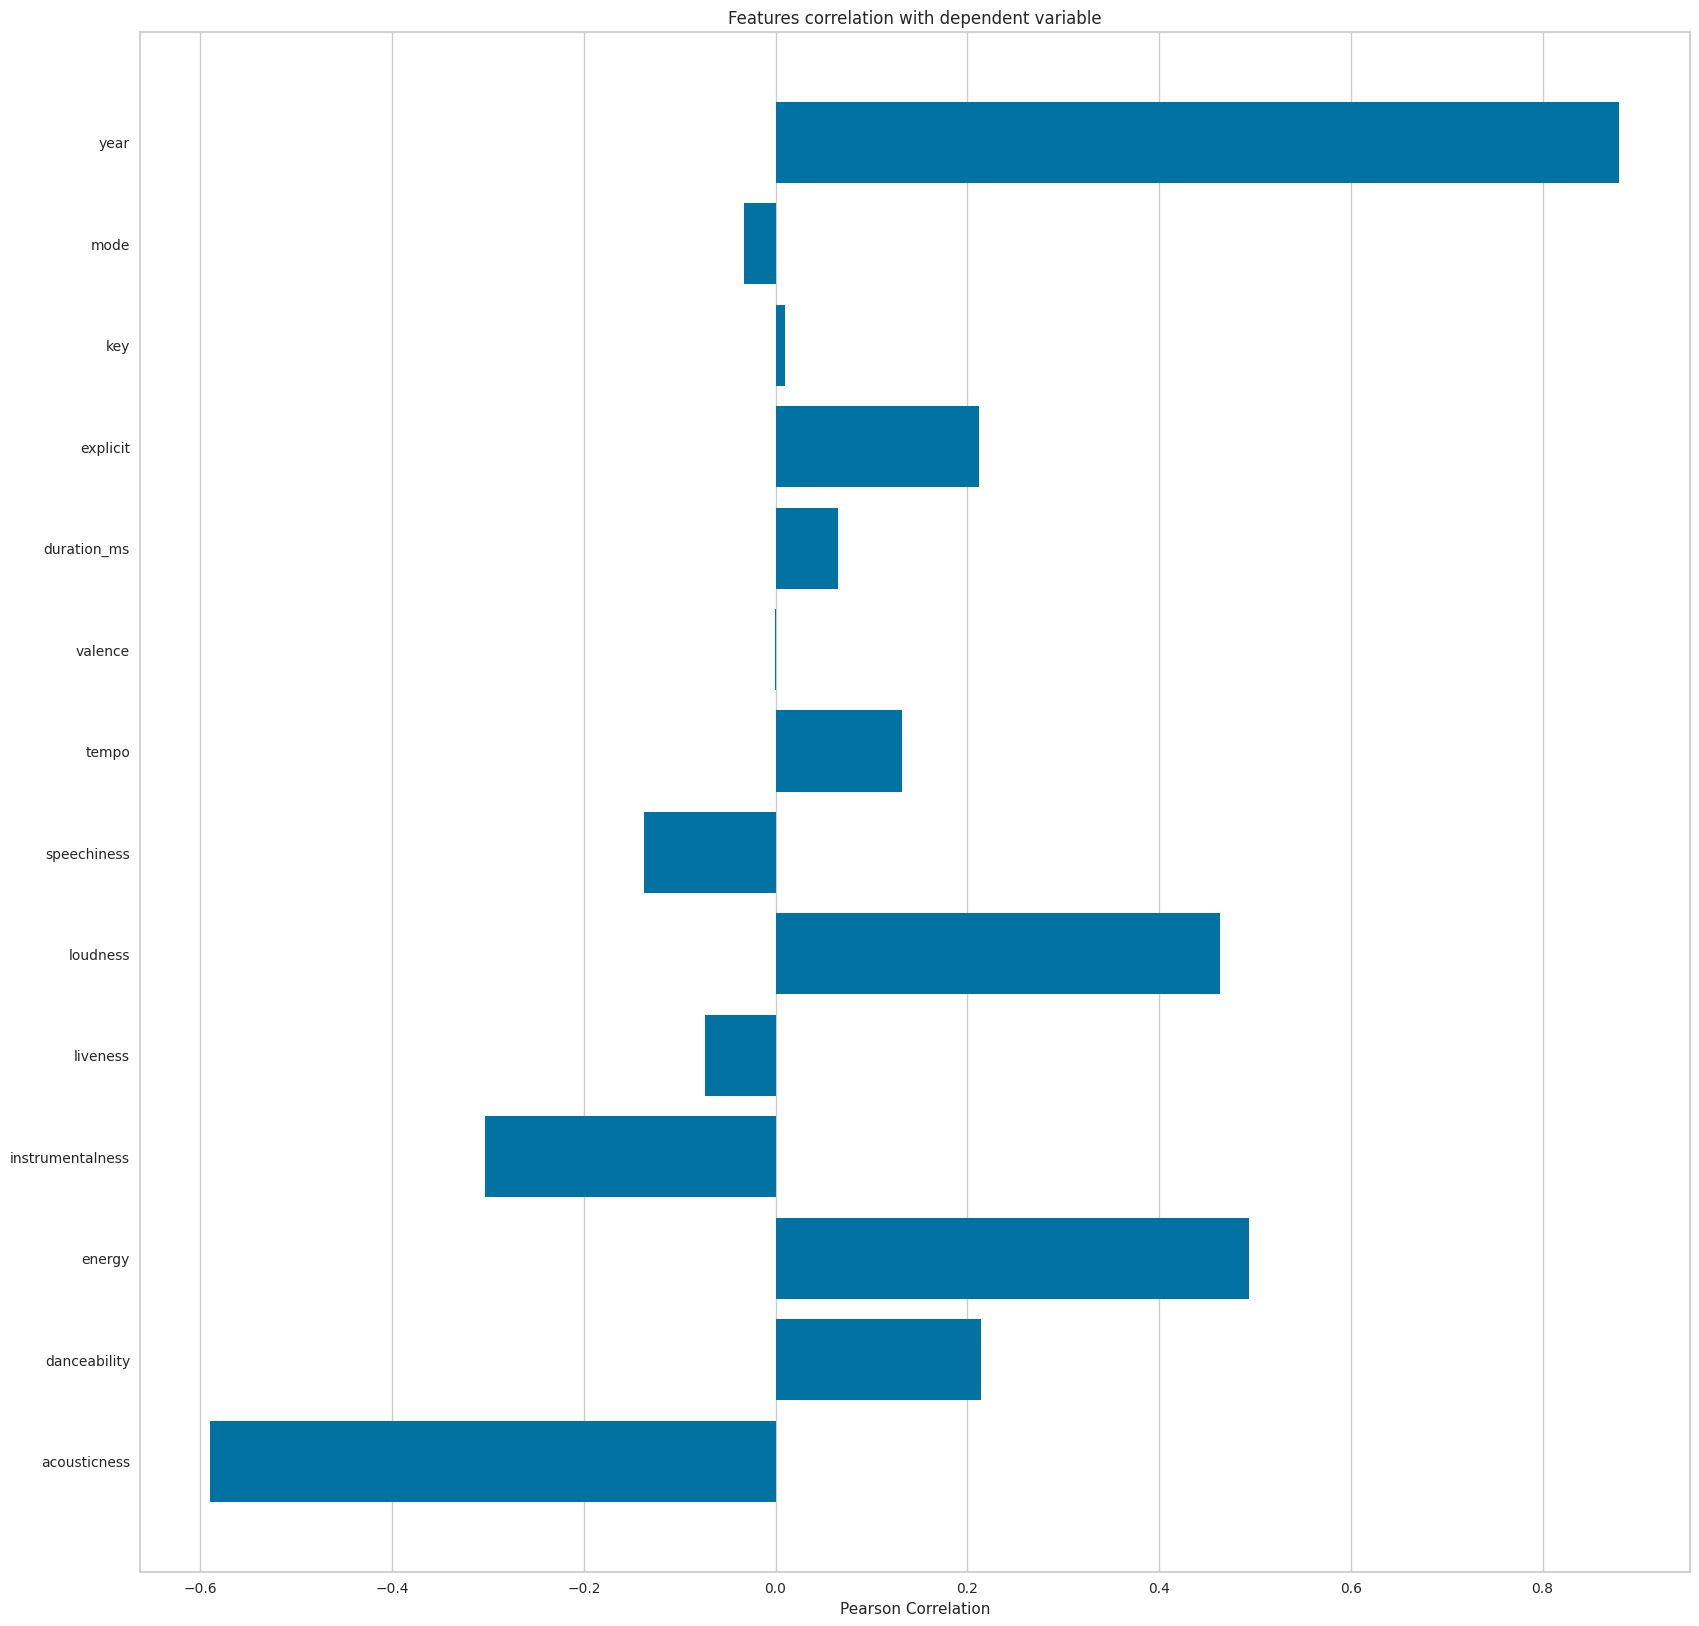

<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [11]:
from yellowbrick.target import FeatureCorrelation

feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_ms','explicit','key','mode','year']

X, y = df[feature_names].toPandas(), df.toPandas()['popularity']

# Create a list of the feature names
features = np.array(feature_names)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(20,20)
visualizer.fit(X, y)     # Fit the data to the visualizer
visualizer.show()


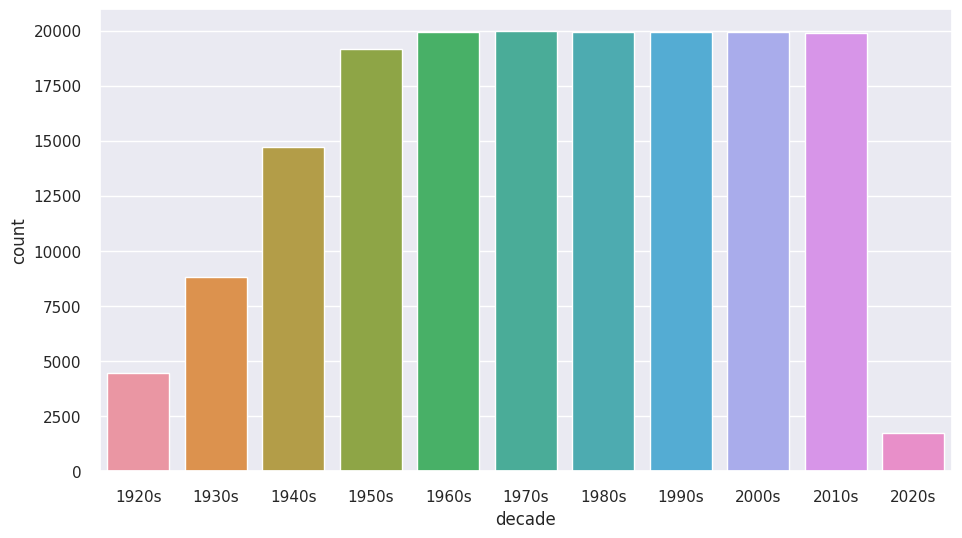

In [12]:
from pyspark.sql import functions as F
@F.udf(StringType())
def get_decade(year):
    period_start = int(year/10) * 10
    decade = '{}s'.format(period_start)
    return decade

df = df.withColumn("decade", get_decade(df['year']))
df.toPandas()["decade"]

# df['decade'] = df.toPandas()['year'].apply(get_decade)

sns.set(rc={'figure.figsize':(11 ,6)})
sns.countplot(x = 'decade', data = df.toPandas())
plt.show()

In [18]:
df.groupBy("year") \
    .avg('acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'valence') \
    .toPandas() 

year  avg(acousticness)  avg(danceability)  avg(energy)  \
0   1959           0.776815           0.489223     0.317006   
1   1990           0.302887           0.545811     0.588700   
2   1975           0.415638           0.524068     0.535026   
3   1977           0.331452           0.537556     0.564964   
4   2003           0.246651           0.576191     0.666573   
..   ...                ...                ...          ...   
95  1941           0.899454           0.482258     0.261043   
96  1931           0.872514           0.572343     0.263996   
97  1937           0.899631           0.556888     0.286996   
98  1929           0.591111           0.647005     0.240513   
99  1933           0.905011           0.603766     0.287361   

    avg(instrumentalness)  avg(liveness)  avg(valence)  
0                0.178431       0.196528      0.487929  
1                0.106783       0.199829      0.534799  
2                0.105624       0.220132      0.578881  
3                0.125981       0.224147      0.588513  
4                0.080836       0.195379      0.534397  
..                    ...            ...           ...  
95               0.446585       0.201997      0.482160  
96               0.346811       0.234141      0.595810  
97               0.335734       0.217991      0.594565  
98               0.219461       0.235988      0.638208  
99               0.130556       0.210155      0.635153  

[100 rows x 7 columns]

In [19]:
sound_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'valence']
fig = px.line(df.groupBy("year") \
    .avg('acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'valence') \
    .toPandas(), x='year', y=df.groupBy("year") \
    .avg('acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'valence') \
    .columns)
fig.show()

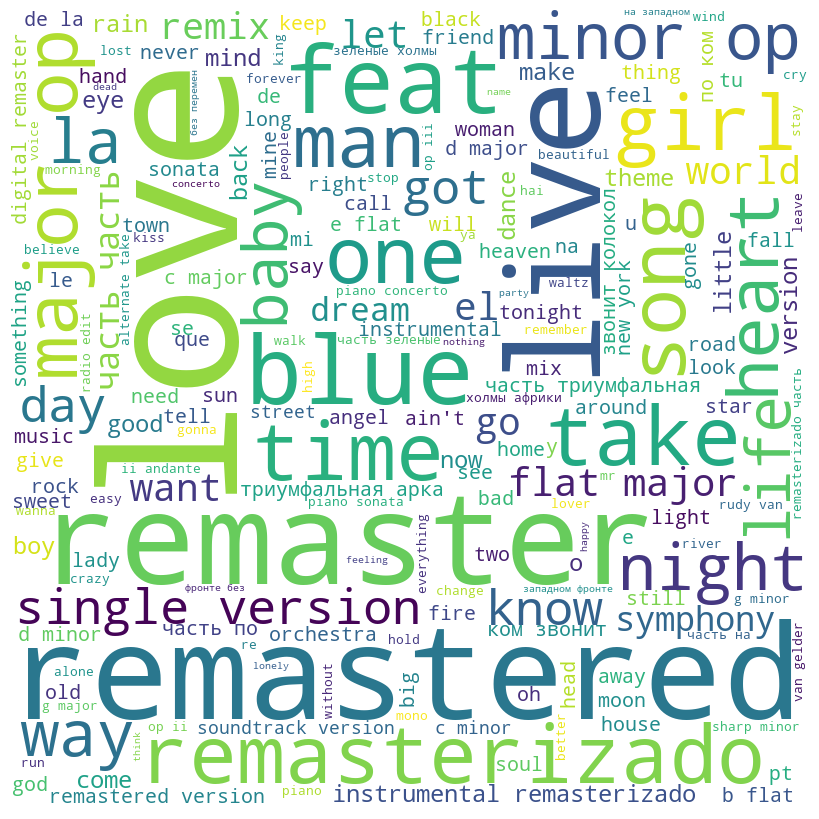

In [21]:
from wordcloud import WordCloud, STOPWORDS

comment_words = ''
stopwords = set(STOPWORDS)
 
for val in df.toPandas()['name']:
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# df.toPandas()['name'].head()

In [27]:
popular_song = df.filter("popularity>=50")
popular_song.show()

+------------+--------------------+------------+-----------+------+--------+--------------------+----------------+---+--------+--------+----+--------------------+----------+------------+-----------+-------+-------+----+------+
|acousticness|             artists|danceability|duration_ms|energy|explicit|                  id|instrumentalness|key|liveness|loudness|mode|                name|popularity|release_date|speechiness|  tempo|valence|year|decade|
+------------+--------------------+------------+-----------+------+--------+--------------------+----------------+---+--------+--------+----+--------------------+----------+------------+-----------+-------+-------+----+------+
|       0.891|     ['Lucio Dalla']|       0.596|     222160| 0.305|       0|3yGyWqmw9eCQPdJJ6...|         1.94E-6|  0|   0.192|  -13.27|   1|            4/3/1943|        54|        1970|      0.046|134.381|  0.782|1970| 1970s|
|       0.728|     ['Mia Martini']|       0.248|     283893| 0.483|       0|5UKMdUAChYAllKDy

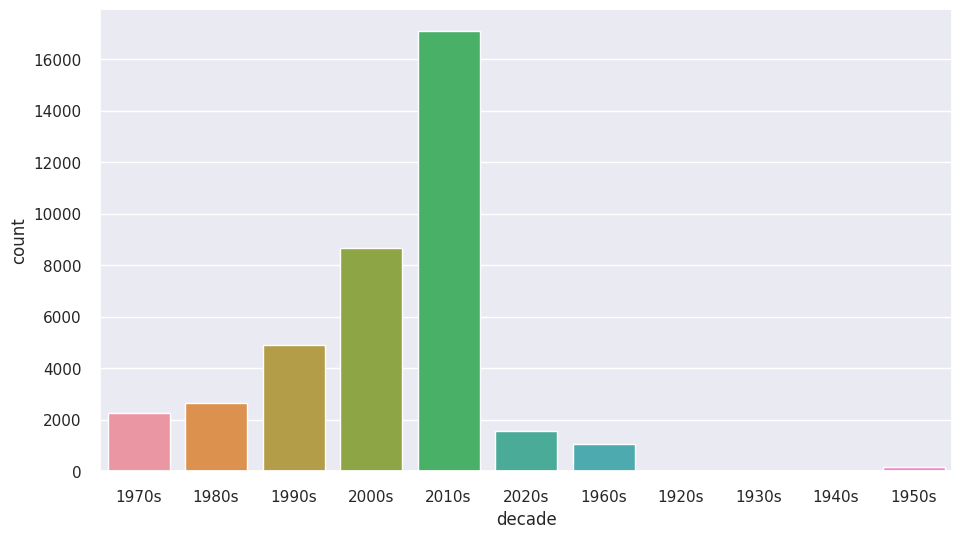

In [28]:
sns.set(rc={'figure.figsize':(11 ,6)})
sns.countplot(x = 'decade', data = popular_song.toPandas())
plt.show()

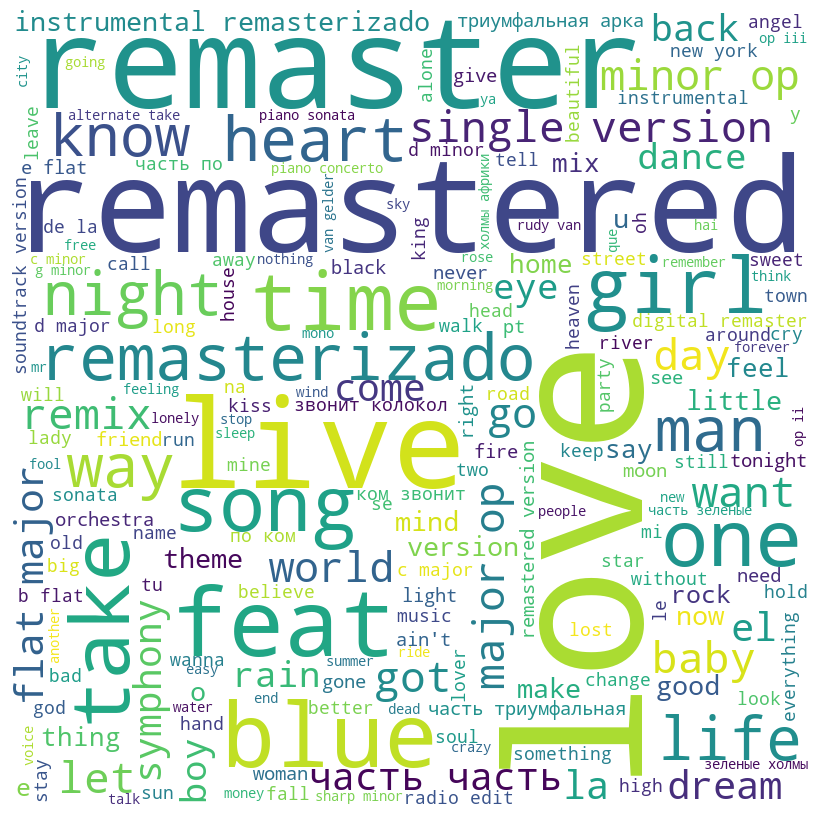

In [29]:
for val in popular_song.toPandas()['name']:
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Clustering Songs with K-Means

In [35]:
from pyspark.ml.feature import VectorAssembler

assemble=VectorAssembler(inputCols=[
 'acousticness',
 'danceability',
 'energy',
 'duration_ms',
 'instrumentalness',
 'valence',
 'tempo',
 'liveness',
 'loudness',
 'popularity',
 'speechiness',
 'year',
 'key'], outputCol='features')
assembled_data=assemble.transform(df)
assembled_data.show(2)

22/09/12 00:53:38 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+------------+--------------------+------------+-----------+------+--------+--------------------+----------------+---+--------+--------+----+--------------------+----------+------------+-----------+-------+-------+----+------+--------------------+
|acousticness|             artists|danceability|duration_ms|energy|explicit|                  id|instrumentalness|key|liveness|loudness|mode|                name|popularity|release_date|speechiness|  tempo|valence|year|decade|            features|
+------------+--------------------+------------+-----------+------+--------+--------------------+----------------+---+--------+--------+----+--------------------+----------+------------+-----------+-------+-------+----+------+--------------------+
|       0.995| ['Carl Woitschach']|       0.708|     158648| 0.195|       0|

In [36]:
from pyspark.ml.feature import StandardScaler

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)

+------------+--------------------+------------+-----------+------+--------+--------------------+----------------+---+--------+--------+----+--------------------+----------+------------+-----------+-------+-------+----+------+--------------------+--------------------+
|acousticness|             artists|danceability|duration_ms|energy|explicit|                  id|instrumentalness|key|liveness|loudness|mode|                name|popularity|release_date|speechiness|  tempo|valence|year|decade|            features|        standardized|
+------------+--------------------+------------+-----------+------+--------+--------------------+----------------+---+--------+--------+----+--------------------+----------+------------+-----------+-------+-------+----+------+--------------------+--------------------+
|       0.995| ['Carl Woitschach']|       0.708|     158648| 0.195|       0|6KbQ3uYMLKb5jDxLF...|           0.563| 10|   0.151| -12.428|   1|Singende Bataillo...|         0|        1928|     0.

In [37]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.37023140853854414
Silhouette Score: 0.31986299098087756
Silhouette Score: 0.31046116117262823
Silhouette Score: 0.27064897248255043
Silhouette Score: 0.17633480278570962
Silhouette Score: 0.25616364844142975
Silhouette Score: 0.23015351756495367
Silhouette Score: 0.22651002939701115


Text(0, 0.5, 'cost')

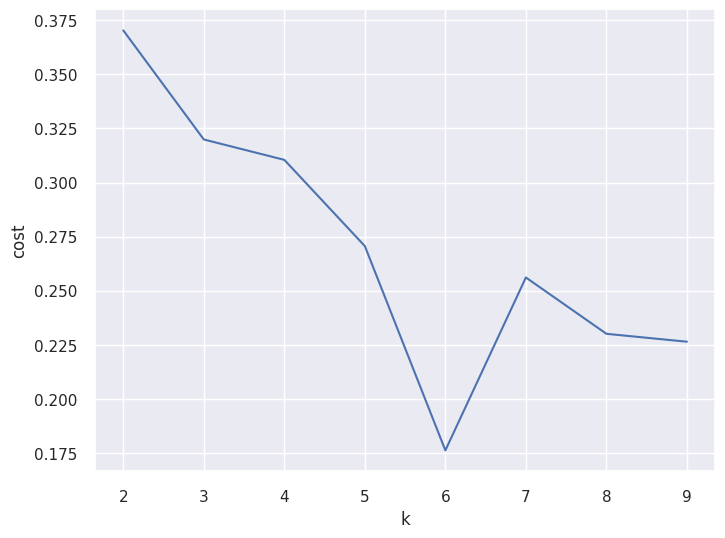

In [38]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [43]:
    KMeans_algo=KMeans(featuresCol='standardized', k=7)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)

In [44]:
output.show()

+------------+--------------------+------------+-----------+-------+--------+--------------------+----------------+---+--------+--------+----+--------------------+----------+------------+-----------+-------+-------+----+------+--------------------+--------------------+----------+
|acousticness|             artists|danceability|duration_ms| energy|explicit|                  id|instrumentalness|key|liveness|loudness|mode|                name|popularity|release_date|speechiness|  tempo|valence|year|decade|            features|        standardized|prediction|
+------------+--------------------+------------+-----------+-------+--------+--------------------+----------------+---+--------+--------+----+--------------------+----------+------------+-----------+-------+-------+----+------+--------------------+--------------------+----------+
|       0.995| ['Carl Woitschach']|       0.708|     158648|  0.195|       0|6KbQ3uYMLKb5jDxLF...|           0.563| 10|   0.151| -12.428|   1|Singende Batail

In [45]:
output.toPandas()['prediction'].unique()

array([5, 0, 1, 4, 3, 2, 6], dtype=int32)

In [48]:
output.toPandas()['prediction'].value_counts()

2    65355
5    33471
6    28866
0    22908
3    10759
1     4290
4     2813
Name: prediction, dtype: int64

In [ ]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

indices = pd.Series(netflix_data.index, index=netflix_data['title']).drop_duplicates()

def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return netflix_data[['title','description']].iloc[movie_indices]